### Simple Sample Baye Opt
While a number of production ready algorithms exist such as:
- MOE
- Spearmint
- hyperopt
- GPyOpt

This notebook handles making a simple algorithm.



Simply put, the Bayesian Optimizers requires:
- **A Gaussian process** 
    - ```sklearn.gaussian_process as gp```
    - From which we will predict the posterior distribution of the target function (function of errors for models).
    - Because a Gaussian distribution is defined by its mean and variance, this model relies on the assumption that the Gaussian process is also completely defined by its mean function and variance function.
        - Until math has another revolution and we discover that we know nothing about math (which I seem to find a lot) we can assume this is a pretty safe assumption (GP ~ mean function & variance function).
        
        
    - I can't phrase this better, so:
    
    ```A GP is a popular probability model, because it induces a posterior distribution over the loss function that is analytically tractable. This allows us to update our beliefs of what looks like, after we have computed the loss for a new set of hyperparameters.``` https://thuijskens.github.io/2016/12/29/bayesian-optimisation/
    
    
    
- **An Aquisition function**
    - Which decides at which point in our target function, we want to sample next.
    
    - A number of well documented aquistion functions exist, listed below:
        - **Probability of Improvement**
            - Looks where a function's **improvement is most likely**
            - Can lead to odd behavior because it relies on the current minimum, rather than the magnatude of possiblity of improvement.
         
        - **Expected improvement (EI)**
            - Looks where a function **may most improve**, aka *maximal expected utility* 
            - EI(x)=𝔼[max{0,f(x)−f(x̂ )}]
            - Crowd favorite

        - **Entropy search**
            - Improves function by **minimizing the uncertainty** of any predicted optimium.
            
        - **Upper Confidence Bound** (UCB)
            - Looks where a function's **improvement is most likely**
            - Looks to exploits possibly uncertainty by finding where the upperbound may be undetermined.
            
            
As to follow the crowd this notebook will use the Expected Improvement function, for reasons I may revisit this notebook to explain.


With these two parts our program should:
    * Given observed values of target function f(x), update the posterior expectation of f using the Gaussian Process.
    * Find new_x that maximises the ```EI: new_x = argmax EI(x)```.
    * Compute the value of f(new_x).
    * Update posterior expectation of f
    
    * Repeat this process for n_iterations

In [17]:
def bayesian_optimisation(n_iters, sample_loss, bounds,
                          n_inital=5,
                          alpha=1e-5, epsilon=1e-7):

    """ baye_opt
    Uses a Gaussian Processe to optimise the loss function `sample_loss`.
    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        
        sample_loss: function.
            Function to be optimised.
        
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        
        n_inital: integer.
            initial number of points from the loss function.
            
        alpha: float.
            Variance of the error term of the GP.
        
        epsilon: float.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_inital, bounds.shape[0])):
        x_list.append(params)
        y_list.append(sample_loss(params))


    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    kernel = gp.kernels.Matern()
    model  = gp.GaussianProcessRegressor(kernel=kernel,
                                        alpha=alpha,
                                        n_restarts_optimizer=10,
                                        normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Finds the next hyperparameter
        next_sample = next_param(expected_improvement, 
                                 model, yp, greater_is_better=True, 
                                 bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])
            # I did not make this line of code, but damn did it help...
            
            
        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)
        
        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        
        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

In [18]:
def next_param(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ next_param
    Proposes the next hyperparameter to sample the loss function for.
    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.
    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x

In [19]:
def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement
    Expected improvement acquisition function.
    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.
    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement

In [5]:
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

def sample_loss(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, scoring='roc_auc', cv=3).mean()

In [9]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

lambdas = np.linspace(1, -4, 25)
gammas = np.linspace(1, -4, 20)

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])

real_loss = [sample_loss(params) for params in param_grid]

# The maximum is at:
param_grid[np.array(real_loss).argmax(), :]

/Users/Nahel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


array([ 0.79166667, -2.42105263])

In [23]:
import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

In [24]:
bounds = np.array([[-4, 1], [-4, 1]])

xp, yp = bayesian_optimisation(n_iters=10, 
                               sample_loss=sample_loss, 
                               bounds=bounds)

In [26]:
xp, yp

(array([[-1.07136108, -2.98912676],
        [-1.85288218, -3.6443537 ],
        [-2.77446135,  0.13460025],
        [ 0.16448657, -0.13220499],
        [-3.79623437, -2.20006093],
        [ 1.        , -4.        ],
        [ 0.66329135, -1.54225793],
        [-3.16724668, -3.85648027],
        [ 0.39130399, -3.82773871],
        [ 0.7297886 , -2.08834604],
        [-1.80861521, -0.04106057],
        [-0.73562073, -1.20158791],
        [-0.13849532, -1.94745619],
        [ 0.52091512, -1.73548918],
        [-1.91669391, -3.68930912]]),
 array([0.84602567, 0.74116565, 0.5       , 0.50716641, 0.83981606,
        0.85759949, 0.94521364, 0.73849854, 0.84840136, 0.97452048,
        0.5       , 0.91728296, 0.96492515, 0.96336844, 0.74053582]))

In [45]:
xp[:,0]

array([-1.07136108, -1.85288218, -2.77446135,  0.16448657, -3.79623437,
        1.        ,  0.66329135, -3.16724668,  0.39130399,  0.7297886 ,
       -1.80861521, -0.73562073, -0.13849532,  0.52091512, -1.91669391])

In [32]:
import numpy as np
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt

In [28]:
def eg_function(x): return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/(x**2 + 1)

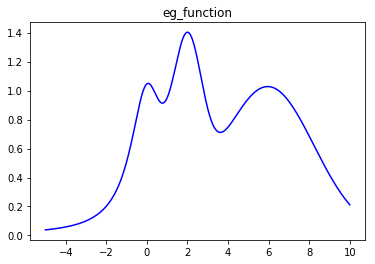

In [59]:
x = np.linspace(-5, 10, 10000).reshape(-1, 1)
y = eg_function(x)
plt.title('eg_function')
plt.plot(x, y, c='b');

In [60]:
bounds = [-5,10]

In [65]:
eg_x = [[np.random.randint(bounds[0],bounds[1])] for i in range(10)]
eg_y = [eg_function(i[0]) for i in eg_x]

In [66]:
kernel = gp.kernels.Matern()
model  = gp.GaussianProcessRegressor(kernel=kernel)

model.fit(eg_x,eg_y)

model.predict([[5]])

array([0.94342237])

In [67]:
eg_y

[0.7474592143361383,
 0.41876478169181863,
 0.41876478169181863,
 0.9434223663015846,
 0.8744491009120414,
 0.9499644397953411,
 0.10030353915196681,
 0.9248374180498474,
 0.9248374180498474,
 0.41876478169181863]

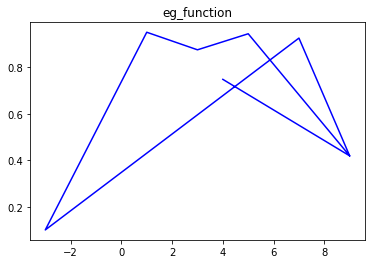

In [68]:
plt.title('eg_function')
plt.plot(eg_x, eg_y, c='b');